In [1]:
# Initial imports
import pandas as pd
from pathlib import Path
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score
from pprint import pprint


# Psycopg2 is a popular PostgreSQL adapter for the Python programming language. It allows Python code to interact with PostgreSQL databases. 
import psycopg2
from psycopg2 import sql

# #Spark imports
# !wget -q https://dlcdn.apache.org/spark/spark-3.5.0/spark-3.5.0-bin-hadoop3.tgz
# !tar xf spark-3.5.0-bin-hadoop3.tgz
# !pip install -q findspark
# !pip install pyspark
# !pip install py4j
# import os
# import sys
# # os.environ["JAVA_HOME"] = "/usr/lib/jvm/java-8-openjdk-amd64"
# # os.environ["SPARK_HOME"] = "/content/spark-3.2.1-bin-hadoop3.2"

# # Start a SparkSession
# import findspark
# findspark.init()
# from pyspark.sql import SparkSession

# Import the time module so we can time our queries.
import time

# Amazon SageMaker and related imports
import sagemaker
import sagemaker.amazon.common as smac
from sagemaker.deserializers import JSONDeserializer
from sagemaker.serializers import CSVSerializer
from sagemaker import get_execution_role
from sagemaker import image_uris
import boto3  # AWS Python sdk

%matplotlib inline

sagemaker.config INFO - Not applying SDK defaults from location: C:\ProgramData\sagemaker\sagemaker\config.yaml
sagemaker.config INFO - Not applying SDK defaults from location: C:\Users\alexa\AppData\Local\sagemaker\sagemaker\config.yaml


In [2]:
#Info for the connection wiht postgres SQL in RDS
PGEND_POINT = 'database-1.cfwmkaw8o6bp.us-east-1.rds.amazonaws.com' #End Point
PGDATABASE_NAME ='heart_attack_prediction_db' #data base name 
PGUSER_NAME = 'postgres'
PGPASSWORD = 'B00TC4MP'

In [3]:
#Defining functions for connection and close connection

def connect():
    conn_string = f"host={PGEND_POINT} port=5432 dbname={PGDATABASE_NAME} user={PGUSER_NAME} password={PGPASSWORD}"
    conn = psycopg2.connect(conn_string)
    print("Connected!")
    
    #Create a cursor object
    cursor = conn.cursor()
    
    return conn, cursor

#Close connection function definition
def close_connection(conn, cursor):
    conn.commit()
    cursor.close()
    conn.close()
    print("Connection closed.")

In [4]:
#Creting the connection with postgres SQL
conn, cursor = connect()

Connected!


# Call this function when you're done with your database operations
close_connection(conn, cursor)

In [5]:
 #SQL SELECT statement that retrieves all columns (*) from the table named heartattackprediction.
query_hat_all = sql.SQL("""
SELECT * FROM heartattackprediction;
""")

In [6]:
#Preparation of the database cursor to execute the SQL query specified by query_hat_all. 
#Once the query is executed, the cursor will hold the result set (if any) 
#returned by the database server.
cur = conn.cursor()
cur.execute(query_hat_all)

In [7]:
#put all the data in heartattackprediction table into a data frame in pandas all the columns name appear
pd_df = pd.DataFrame(cur.fetchall(), columns=['Patient ID', 'Age', 'Sex','Cholesterol', 'Blood Pressure','Heart Rate','Diabetes','Family History','Smoking','Obesity','Alcohol Consumption','Exercise Hours Per Week','Diet','Previous Heart Problems','Medication Use','Stress Level','Sedentary Hours Per Day','Income','BMI','Triglycerides','Physical Activity Days Per Week','Sleep Hours Per Day','Country','Continent','Hemisphere','Heart Attack Risk'])
pd_df.head(5)

,Patient ID,Age,Sex,Cholesterol,Blood Pressure,Heart Rate,Diabetes,Family History,Smoking,Obesity,...,Sedentary Hours Per Day,Income,BMI,Triglycerides,Physical Activity Days Per Week,Sleep Hours Per Day,Country,Continent,Hemisphere,Heart Attack Risk
0,BMW7812,67,Male,208,158/88,72,0,0,1,0,...,6.615001,261404,31.251233,286,0,6,Argentina,South America,Southern Hemisphere,0
1,CZE1114,21,Male,389,165/93,98,1,1,1,1,...,4.963459,285768,27.194973,235,1,7,Canada,North America,Northern Hemisphere,0
2,BNI9906,21,Female,324,174/99,72,1,0,0,0,...,9.463426,235282,28.176571,587,4,4,France,Europe,Northern Hemisphere,0
3,JLN3497,84,Male,383,163/100,73,1,1,1,0,...,7.648981,125640,36.464704,378,3,4,Canada,North America,Northern Hemisphere,0
4,GFO8847,66,Male,318,91/88,93,1,1,1,1,...,1.514821,160555,21.809144,231,1,5,Thailand,Asia,Northern Hemisphere,0


In [8]:
pd_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 8763 entries, 0 to 8762
Data columns (total 26 columns):
 #   Column                           Non-Null Count  Dtype  
---  ------                           --------------  -----  
 0   Patient ID                       8763 non-null   object 
 1   Age                              8763 non-null   int64  
 2   Sex                              8763 non-null   object 
 3   Cholesterol                      8763 non-null   int64  
 4   Blood Pressure                   8763 non-null   object 
 5   Heart Rate                       8763 non-null   int64  
 6   Diabetes                         8763 non-null   int64  
 7   Family History                   8763 non-null   int64  
 8   Smoking                          8763 non-null   int64  
 9   Obesity                          8763 non-null   int64  
 10  Alcohol Consumption              8763 non-null   int64  
 11  Exercise Hours Per Week          8763 non-null   float64
 12  Diet                

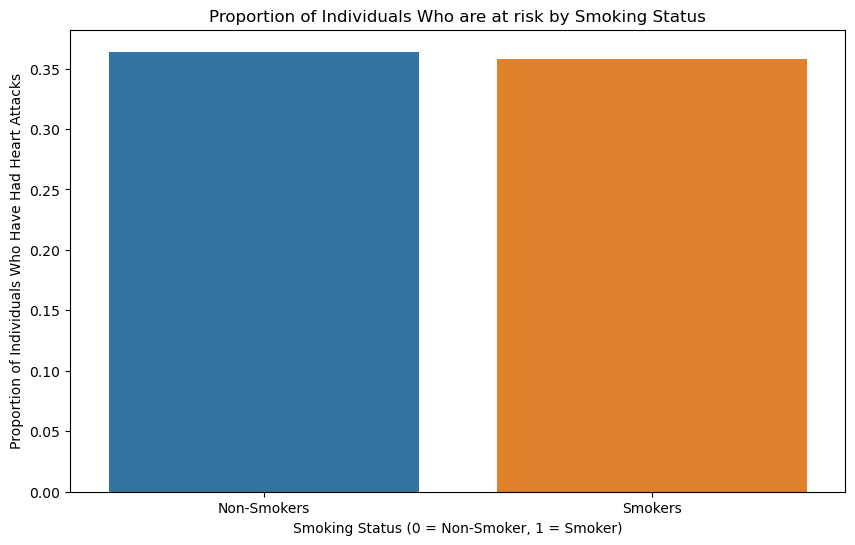

In [9]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# Assuming 'smoking' and 'heart attack risk' are binary columns where:
# 'smoking' - 0: does not smoke, 1: does smoke
# 'heart attack risk' - 0: no risk of heart attack, 1: had heart attack

# Calculating the proportion of individuals who've had heart attacks among smokers and non-smokers
proportion_had_heart_attack = pd_df.groupby('Smoking')['Heart Attack Risk'].mean().reset_index()

# Creating the bar graph to visualize the proportion
plt.figure(figsize=(10, 6))
sns.barplot(x='Smoking', y='Heart Attack Risk', data=proportion_had_heart_attack)
plt.title('Proportion of Individuals Who are at risk by Smoking Status')
plt.xlabel('Smoking Status (0 = Non-Smoker, 1 = Smoker)')
plt.ylabel('Proportion of Individuals Who Have Had Heart Attacks')
plt.xticks([0, 1], ['Non-Smokers', 'Smokers'])
plt.show()

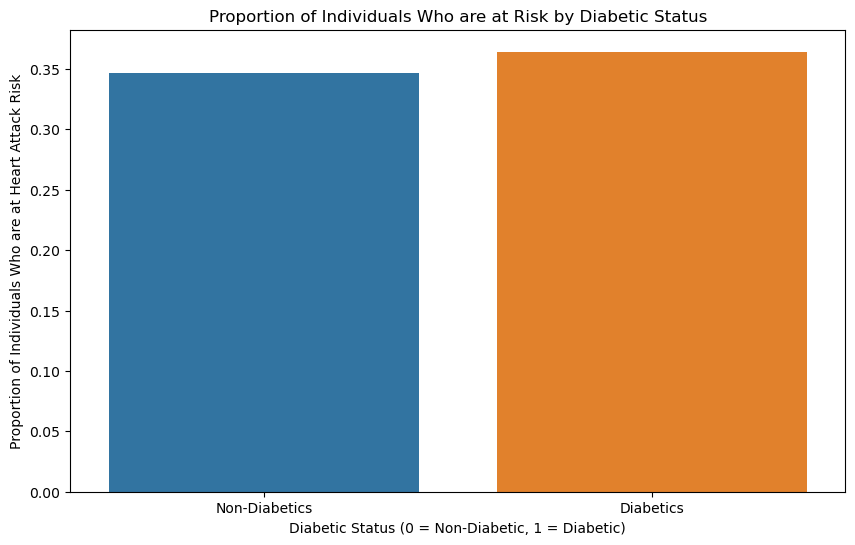

In [10]:
# Assuming 'Diabetes' and 'heart attack risk' are binary columns where:
# 'Diabetes' - 0: is not diabetic, 1: is diabetic
# 'heart attack risk' - 0: no risk of heart attack, 1: risk of heart attack

# Calculating the proportion of individuals who've had heart attacks among diabetics and non-diabetics
proportion_had_heart_attack_2 = pd_df.groupby('Diabetes')['Heart Attack Risk'].mean().reset_index()

# Creating the bar graph to visualize the proportion
plt.figure(figsize=(10, 6))
sns.barplot(x='Diabetes', y='Heart Attack Risk', data=proportion_had_heart_attack_2)
plt.title('Proportion of Individuals Who are at Risk by Diabetic Status')
plt.xlabel('Diabetic Status (0 = Non-Diabetic, 1 = Diabetic)')
plt.ylabel('Proportion of Individuals Who are at Heart Attack Risk')
plt.xticks([0, 1], ['Non-Diabetics', 'Diabetics'])
plt.show()

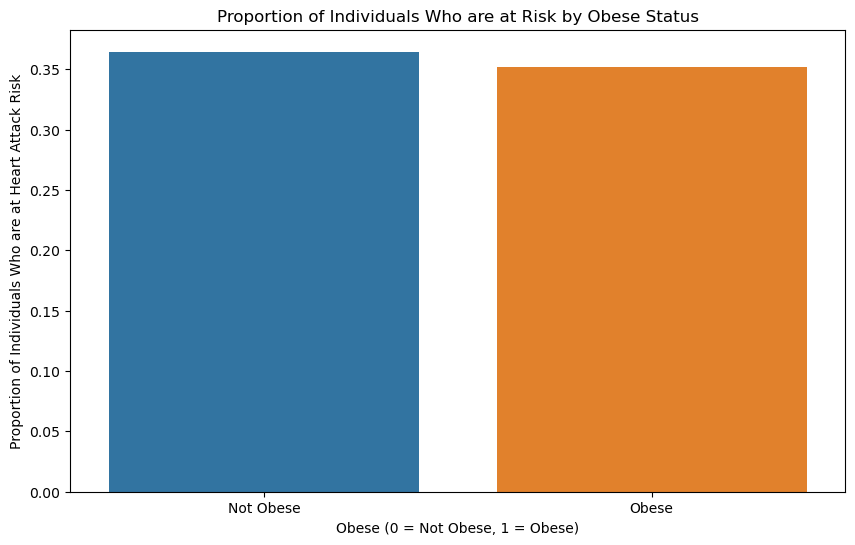

In [11]:
# Assuming 'Obesity' and 'heart attack risk' are binary columns where:
# 'Obesity' - 0: is not obese, 1: is  obese
# 'heart attack risk' - 0: no risk of heart attack, 1: risk of heart attack

# Calculating the proportion of individuals who've had heart attacks among obese and non-obese individuals
proportion_had_heart_attack_3 = pd_df.groupby('Obesity')['Heart Attack Risk'].mean().reset_index()

# Creating the bar graph to visualize the proportion
plt.figure(figsize=(10, 6))
sns.barplot(x='Obesity', y='Heart Attack Risk', data=proportion_had_heart_attack_3)
plt.title('Proportion of Individuals Who are at Risk by Obese Status')
plt.xlabel('Obese (0 = Not Obese, 1 = Obese)')
plt.ylabel('Proportion of Individuals Who are at Heart Attack Risk')
plt.xticks([0, 1], ['Not Obese', 'Obese'])
plt.show()

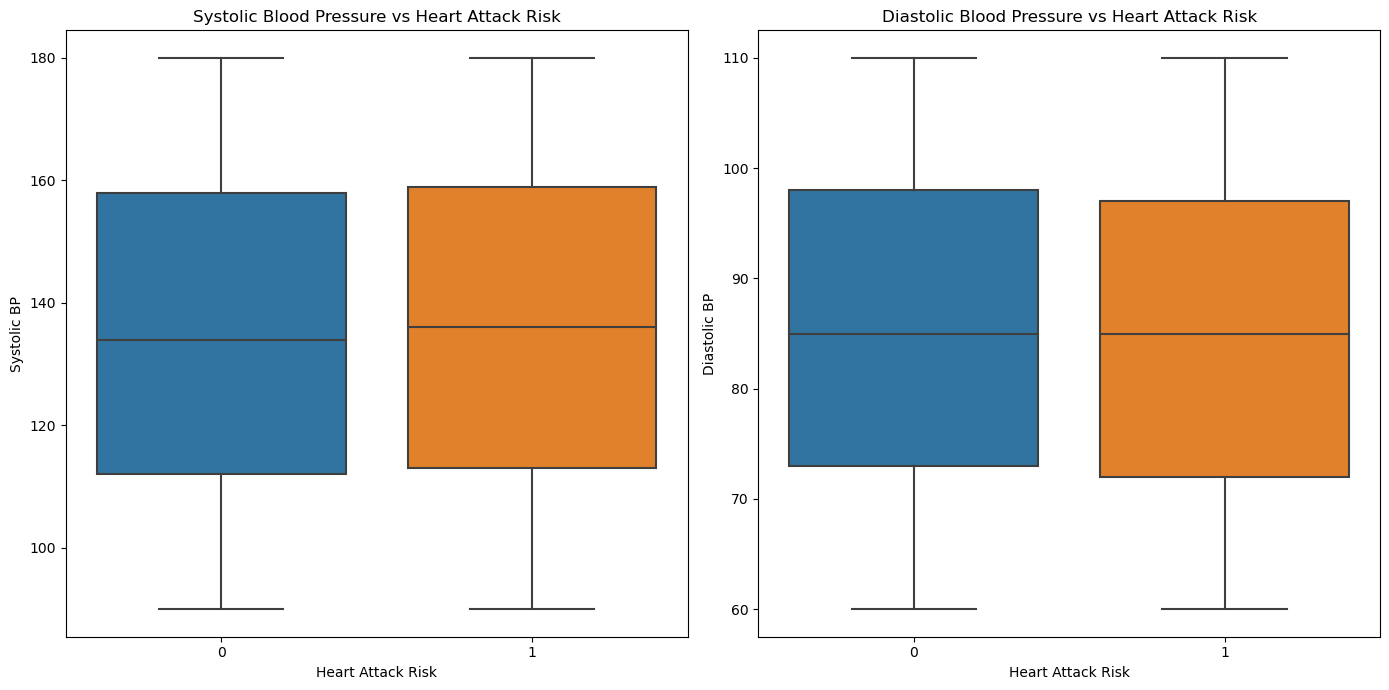

In [12]:
# Assuming 'Blood Pressure' is a string of the form 'systolic/diastolic'
# and 'Heart Attack Risk' is a binary variable

# Split the 'Blood Pressure' column into 'Systolic' and 'Diastolic'
pd_df[['Systolic BP', 'Diastolic BP']] = pd_df['Blood Pressure'].str.split('/', expand=True).astype(int)

# Visualize the correlation using a box plot
plt.figure(figsize=(14, 7))

# Boxplot for Systolic Blood Pressure
plt.subplot(1, 2, 1)
sns.boxplot(x='Heart Attack Risk', y='Systolic BP', data=pd_df)
plt.title('Systolic Blood Pressure vs Heart Attack Risk')

# Boxplot for Diastolic Blood Pressure
plt.subplot(1, 2, 2)
sns.boxplot(x='Heart Attack Risk', y='Diastolic BP', data=pd_df)
plt.title('Diastolic Blood Pressure vs Heart Attack Risk')

plt.tight_layout()
plt.show()

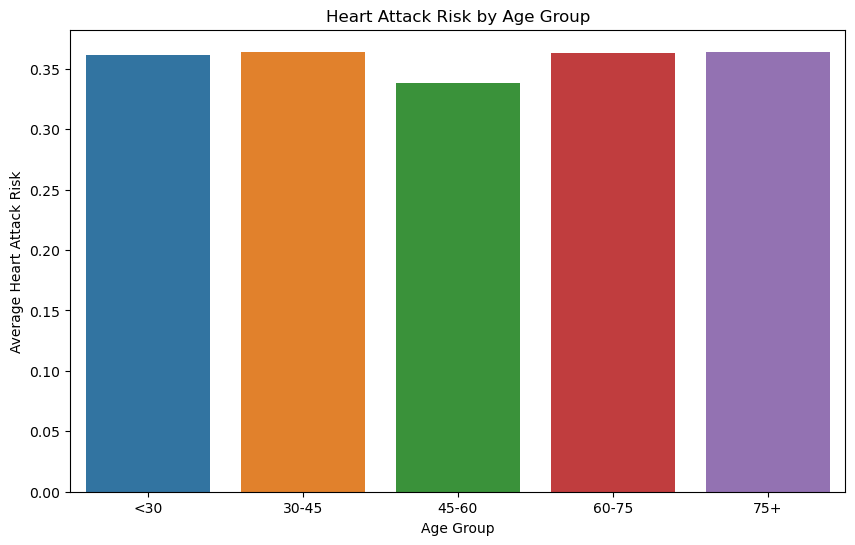

In [13]:


# Categorize 'Age' into groups. Adjust the bins according to your data's specific age range distribution.
pd_df['Age Group'] = pd.cut(pd_df['Age'], bins=[0, 30, 45, 60, 75, 90], labels=['<30', '30-45', '45-60', '60-75', '75+'])

# Calculate the mean heart attack risk for each age group
age_group_risk = pd_df.groupby('Age Group')['Heart Attack Risk'].mean().reset_index()

# Creating the bar plot
plt.figure(figsize=(10, 6))
sns.barplot(x='Age Group', y='Heart Attack Risk', data=age_group_risk)
plt.title('Heart Attack Risk by Age Group')
plt.xlabel('Age Group')
plt.ylabel('Average Heart Attack Risk')
plt.show()

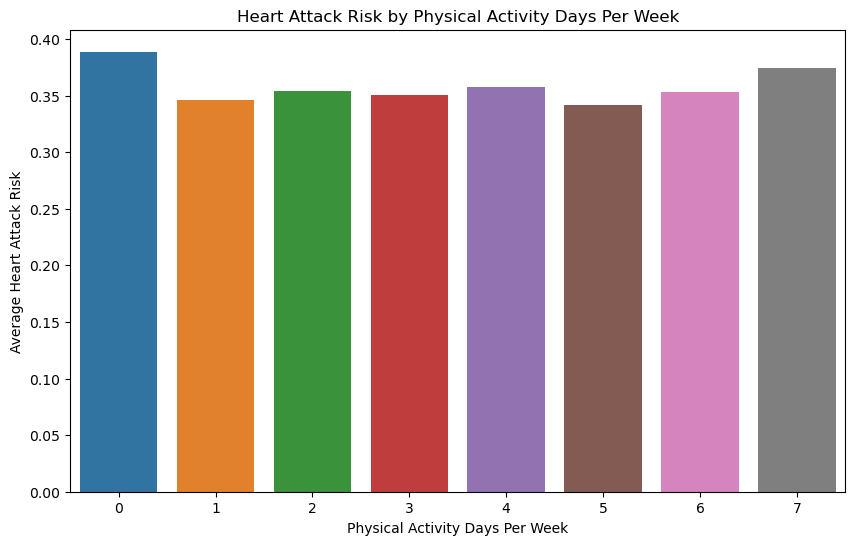

In [14]:

# Calculate the mean heart attack risk for each category of physical activity days
activity_risk = pd_df.groupby('Physical Activity Days Per Week')['Heart Attack Risk'].mean().reset_index()

# Creating the bar plot
plt.figure(figsize=(10, 6))
sns.barplot(x='Physical Activity Days Per Week', y='Heart Attack Risk', data=activity_risk)
plt.title('Heart Attack Risk by Physical Activity Days Per Week')
plt.xlabel('Physical Activity Days Per Week')
plt.ylabel('Average Heart Attack Risk')
plt.show()


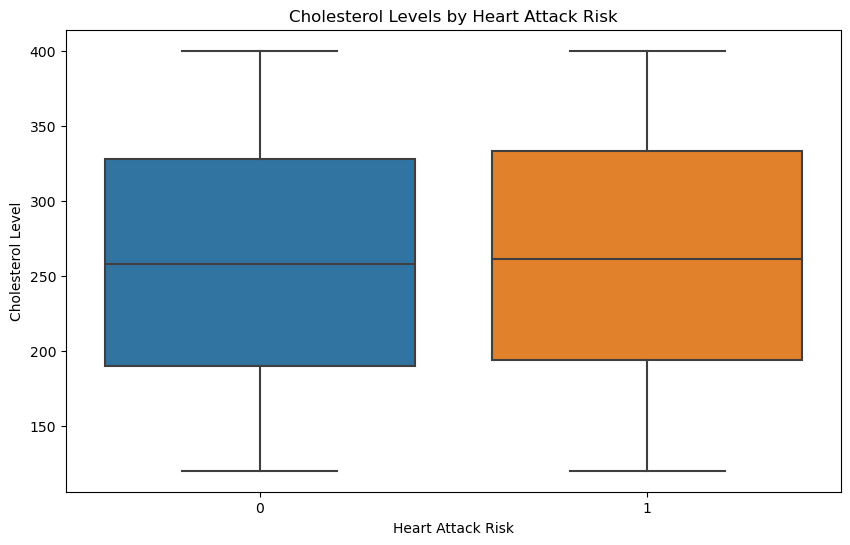

In [15]:
# Creating a boxplot to visualize the correlation between Cholesterol levels and Heart Attack Risk
plt.figure(figsize=(10, 6))
sns.boxplot(x='Heart Attack Risk', y='Cholesterol', data=pd_df)
plt.title('Cholesterol Levels by Heart Attack Risk')
plt.xlabel('Heart Attack Risk')
plt.ylabel('Cholesterol Level')
plt.show()

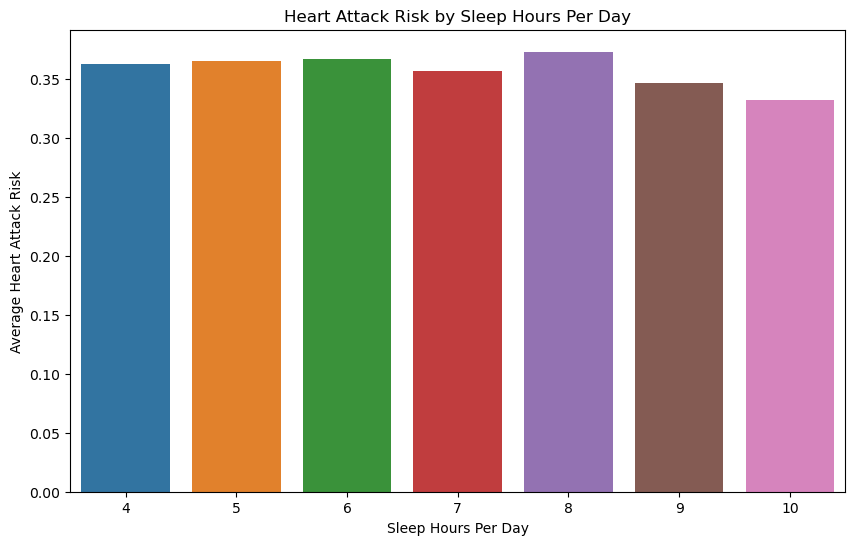

In [16]:
# Calculate the mean heart attack risk for each category of sleep hours
sleep_risk = pd_df.groupby('Sleep Hours Per Day')['Heart Attack Risk'].mean().reset_index()

# Creating the bar plot
plt.figure(figsize=(10, 6))
sns.barplot(x='Sleep Hours Per Day', y='Heart Attack Risk', data=sleep_risk)
plt.title('Heart Attack Risk by Sleep Hours Per Day')
plt.xlabel('Sleep Hours Per Day')
plt.ylabel('Average Heart Attack Risk')
plt.show()

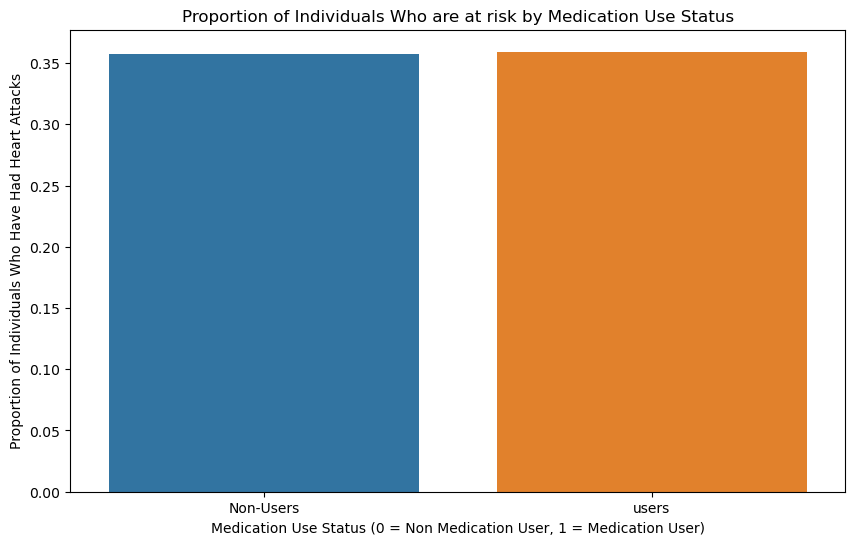

In [18]:
# Assuming 'Medication use' and 'heart attack risk' are binary columns where:
# 'Medication Use' - 0: does not use, 1: does use
# 'heart attack risk' - 0: no risk of heart attack, 1: had heart attack

# Calculating the proportion of individuals who've had heart attacks among smokers and non-smokers
proportion_had_heart_attack_5 = pd_df.groupby('Medication Use')['Heart Attack Risk'].mean().reset_index()

# Creating the bar graph to visualize the proportion
plt.figure(figsize=(10, 6))
sns.barplot(x='Medication Use', y='Heart Attack Risk', data=proportion_had_heart_attack_5)
plt.title('Proportion of Individuals Who are at risk by Medication Use Status')
plt.xlabel('Medication Use Status (0 = Non Medication User, 1 = Medication User)')
plt.ylabel('Proportion of Individuals Who Have Had Heart Attacks')
plt.xticks([0, 1], ['Non-Users', 'users'])
plt.show()

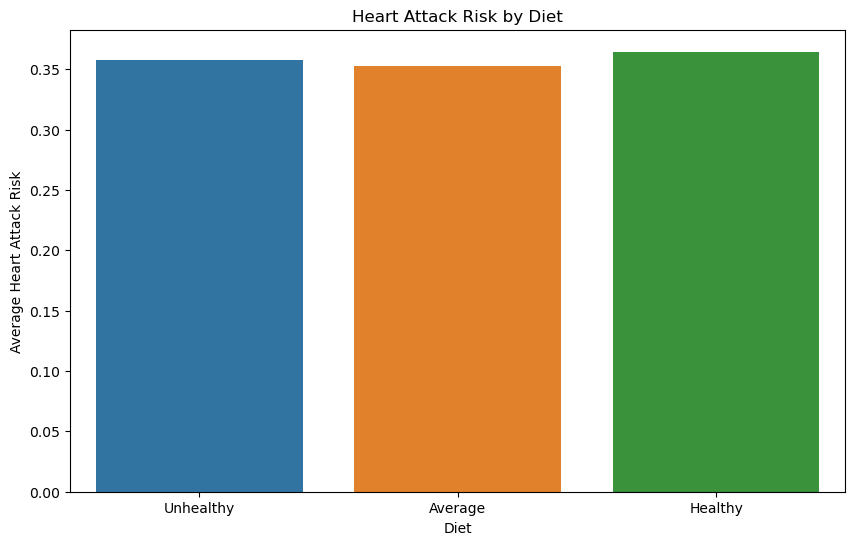

In [19]:
# Calculate the mean heart attack risk for each diet category
diet_risk = pd_df.groupby('Diet')['Heart Attack Risk'].mean().reset_index()

# Creating the bar plot
plt.figure(figsize=(10, 6))
sns.barplot(x='Diet', y='Heart Attack Risk', data=diet_risk, order=['Unhealthy', 'Average', 'Healthy'])
plt.title('Heart Attack Risk by Diet')
plt.xlabel('Diet')
plt.ylabel('Average Heart Attack Risk')
plt.show()